In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import numpy as np
import random
import pickle
import sys
import trainlib

In [ ]:
with open('inputs.p', 'rb') as infile:
    inputs = pickle.load(infile)
with open('corpus.p', 'rb') as infile:
    corp = pickle.load(infile)

In [ ]:
agg_inputs = reduce(lambda a,b:a+b, inputs, [])

In [ ]:
len(corp)

So we need 95 dimensional inputs/outputs for one-hot encoding.

In [ ]:
tune_start_symbol = '$'
tune_end_symbol = '`'
ord(tune_start_symbol), ord(tune_end_symbol)

In [ ]:
assert agg_inputs.count(ord(tune_start_symbol)) == agg_inputs.count(ord(tune_end_symbol)) == len(inputs), \
    'tune_start_symbol or tune_end_symbol may have been used in tunes'
print len(inputs)

In [ ]:
def zip_iseq(iseq):
    groups = []
    last_group = []
    for x in iseq:
        if not len(last_group):
            last_group.append(x)
        elif x == last_group[-1] + 1:
            last_group.append(x)
        else:
            if len(last_group) == 1:
                groups.append('{}'.format(last_group[0]))
            elif len(last_group) == 2:
                for y in last_group:
                    groups.append('{}'.format(y))
            else:
                assert len(last_group)
                groups.append('{}-{}'.format(last_group[0], last_group[-1]))
            last_group = [x]
    groups.append('{}-{}'.format(last_group[0], last_group[-1]))
    last_group = []
    return ','.join(groups)

In [ ]:
zip_iseq(sorted(list(set(agg_inputs))))

## Demo: `torch.cat`

In [ ]:
_inputs = [Variable(torch.randn((1, 3)))
          for _ in range(5)]

In [ ]:
torch.cat(_inputs)

In [ ]:
Variable(torch.randn((5, 3)))

## Explore how to pack and pad

In [1]:
import pickle
import trainlib
import trainlib
import torch
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence
import torch.nn as nn
from torch.autograd import Variable

In [2]:
with open('inputs.p', 'rb') as infile: inputs = pickle.load(infile)
with open('corpus.p', 'rb') as infile: corp = pickle.load(infile)
dl = trainlib.dataloader(inputs, (25, 30), batch_size=5)

In [3]:
seqs = next(dl)

In [4]:
map(len, seqs)

[30, 29, 28, 27, 26]

In [5]:
t = trainlib.one_hot_tensor(corp, seqs)
t.size()

torch.Size([30, 5, 95])

In [6]:
packed_t = pack_padded_sequence(Variable(t), map(len, seqs))
packed_t

PackedSequence(data=Variable containing:
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
    0     0     1  ...      0     0     0
       ...          ⋱          ...       
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 140x95]
, batch_sizes=[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 3, 2, 1])

In [7]:
lstm = nn.LSTM(95, 20, 1)
hidden = (Variable(torch.zeros(1, 5, 20)), Variable(torch.zeros(1, 5, 20)))

In [8]:
packed_o, hidden = lstm(packed_t, hidden)

In [21]:
o, seq_lens = pad_packed_sequence(packed_o)
o.size(), seq_lens

(torch.Size([30, 5, 20]), [30, 29, 28, 27, 26])

In [18]:
o.transpose(0, 1).size()

torch.Size([5, 30, 20])

In [ ]:
o = 

In [24]:
x = torch.FloatTensor([[[1,2,3],[4,5,6]],[[7,8,9],[10,11,12]]])

In [26]:
x


(0 ,.,.) = 
   1   2   3
   4   5   6

(1 ,.,.) = 
   7   8   9
  10  11  12
[torch.FloatTensor of size 2x2x3]

In [29]:
x.view(-1, 3)


  1   2   3
  4   5   6
  7   8   9
 10  11  12
[torch.FloatTensor of size 4x3]

In [40]:
seq_lens = [2, 1]
torch.cat([x[i][:seq_lens[i]] for i in range(len(seq_lens))])


 1  2  3
 4  5  6
 7  8  9
[torch.FloatTensor of size 3x3]

# Testing

## `dataloaders`

In [1]:
import pickle
import trainlib
import copy
import dataloaders as dl
with open('inputs.p', 'rb') as infile:
    inputs = pickle.load(infile)
with open('corpus.p', 'rb') as infile:
    corp = pickle.load(infile)
trainset, validset = trainlib.divide_train_validation(inputs)

In [2]:
vdl = dl.ValidationDataloader(validset)

In [3]:
seqs = next(vdl)

In [4]:
len(seqs)

225

In [6]:
atnoldl = dl.AcrossTuneNonOverlapDataloader(trainset, (25, 30), batch_size=5, strict_len_lims=True)

In [8]:
seqs = next(atnoldl)

In [10]:
map(len, seqs)

[29, 27, 25, 25, 25]

## `trainers`

In [1]:
import trainers
import models
import pickle
import trainlib
import dataloaders as dl
import torch.optim as optim
import torch.nn as nn
from utils import TwoWayDictionary
with open('inputs.p', 'rb') as infile:
    inputs = pickle.load(infile)
with open('corpus.p', 'rb') as infile:
    corp = pickle.load(infile)
trainset, validset = trainlib.divide_train_validation(inputs)

In [2]:
def curriculum(epoch):
    return (25, 30)
net = models.MusicGenNet(10, 95,
                 n_layers=1,
                 using_gru=False,
                 dropout=0.0)
loaders = {
    'train': dl.AcrossTuneNonOverlapDataloader(trainset, (25, 30), batch_size=500, strict_len_lims=True),
    'valid': dl.ValidationDataloader(validset)
}
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

In [3]:
curr_trainer = trainers.CurriculumTrainer(net, loaders, corp, criterion, optimizer, curriculum,
                 False, True)
seqs = next(loaders['train'])

In [4]:
curr_trainer.evaluate_loss(seqs, loaders['train'].batch_size)

Variable containing:
 4.6006
[torch.FloatTensor of size 1]

In [2]:
def curriculum(epoch):
    return (25, 30)
net = models.MusicGenNet(10, 95,
                 n_layers=1,
                 using_gru=False,
                 dropout=0.0)
loaders = {
    'train': dl.AcrossTuneNonOverlapDataloader(trainset, (25, 30), batch_size=500, strict_len_lims=True),
    'valid': dl.ValidationDataloader(validset)
}
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())
curr_trainer = trainers.CurriculumTrainer(net, loaders, corp, criterion, optimizer, curriculum,
                 False, True)

In [3]:
curr_trainer.train(300)

[epoch 0] 4.8198621273
training loss: 4.57180452347
validation loss: 4.5681438446


KeyboardInterrupt: 

# LSTM

## How to do random sampling:

```
if self.random_output_sampling:
    samples = torch.stack([torch.stack([torch.multinomial(output[i][j], 1)
                      for j in range(output.size(1))])
                      for i in range(output.size(0))])
else:
    _, samples = torch.max(output, 2)
# end of block
return samples
```

## Sample instantiation of `SingleLayerLSTMNet`

In [ ]:
from nn import SingleLayerLSTMNet, init_lstm_states
import trainlib

In [ ]:
n_lstm = 10
hidden_size = (1, 1, n_lstm)
net = SingleLayerLSTMNet(
    n_lstm,
    len(corp), 
    (
        Variable(torch.normal(mean=0, std=torch.ones(*hidden_size)), requires_grad=True),
        Variable(torch.zeros(*hidden_size), requires_grad=True)
    ))
with open('inputs.p', 'rb') as infile:
    inputs = pickle.load(infile)
tl = trainlib.dataloader(inputs, (25, 30), batch_size=1)

In [ ]:
seqs = next(tl)

In [ ]:
outputs = net.forward(Variable(trainlib.one_hot_tensor(corp, seqs)))

In [ ]:
classes = Variable((torch.ones(len(seqs[0])) * 50).long())

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
outputs.transpose(0, 1)[0].size(), classes.size()

In [ ]:
loss = criterion(outputs.transpose(0, 1)[0], classes)

In [ ]:
loss.backward()

## Currently reading:

- http://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html
- http://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html#lstm-s-in-pytorch
- http://pytorch.org/docs/0.3.1/nn.html#lstm

Training test field:

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import numpy as np
import random
import pickle
import sys
import trainlib
from models import SingleLayerLSTMNet, init_lstm_states

In [ ]:
with open('inputs.p', 'rb') as infile:
    inputs = pickle.load(infile)
with open('corpus.p', 'rb') as infile:
    corp = pickle.load(infile)
net = SingleLayerLSTMNet(10, len(corp))
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001)
tl = trainlib.dataloader(inputs, (25, 30), batch_size=1)

# See what the scores are before training
# Note that element i,j of the output is the score for tag j for word i.
seqs = next(tl)
inputs = Variable(trainlib.one_hot_tensor(corp, seqs))
targets = Variable(trainlib.target_tensor(corp, seqs))
outputs = net(inputs)
losses = [criterion(outputs.transpose(0, 1)[i][:-1],
                    targets.transpose(0, 1)[i]) 
          for i in range(outputs.size(1))]
print losses
print inputs.size(), outputs.size()

In [ ]:
for epoch in range(300):  # again, normally you would NOT do 300 epochs, it is toy data
    seqs = next(tl)
    inputs = Variable(trainlib.one_hot_tensor(corp, seqs))
    targets = Variable(trainlib.target_tensor(corp, seqs))
    
    outputs = net(inputs)
    loss = 0
    for i in range(outputs.size(1)):
        loss += criterion(outputs.transpose(0, 1)[i][:-1],
                          targets.transpose(0, 1)[i])
    loss /= (outputs.size(1) * 1.0)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print loss

In [ ]:
# See what the scores are after training
inputs = prepare_sequence(training_data[0][0], word_to_ix)
tag_scores = model(inputs)
# The sentence is "the dog ate the apple".  i,j corresponds to score for tag j
#  for word i. The predicted tag is the maximum scoring tag.
# Here, we can see the predicted sequence below is 0 1 2 0 1
# since 0 is index of the maximum value of row 1,
# 1 is the index of maximum value of row 2, etc.
# Which is DET NOUN VERB DET NOUN, the correct sequence!
print(tag_scores)

## Debug: Why's there `RuntimeError: Trying to backward through the graph a second time`

Minimum working example (reproduction of the error), from http://pytorch.org/docs/master/nn.html#torch.nn.LSTM

In [ ]:
lstm = nn.LSTM(10, 20, 2)
inputs = Variable(torch.randn(5, 3, 10))
hidden = (Variable(torch.randn(2, 3, 20), requires_grad=True),
          Variable(torch.randn(2, 3, 20), requires_grad=True))
outputs, hidden = lstm(inputs, hidden)
loss = outputs.sum()

In [ ]:
loss.backward()

In [ ]:
hidden[1].grad

In [ ]:
lstm.zero_grad()
print hidden[0].grad

In [ ]:
outputs, hidden = lstm(inputs, hidden)
loss = outputs.sum()

In [ ]:
loss.backward()

In [ ]:
with open('inputs.p', 'rb') as infile:
    inputs = pickle.load(infile)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
plt.hist(map(len, inputs));

## Teaching force + curriculum learning

In [1]:
from models import SingleLayerLSTMNet
import trainlib
from trainlib import train_teachingforce_curriculum, divide_train_validation
import torch.nn as nn
from torch.autograd import Variable
import pickle
import torch

In [2]:
net = SingleLayerLSTMNet(100, 95)
with open('inputs.p', 'rb') as infile: inputs = pickle.load(infile)
with open('corpus.p', 'rb') as infile: corp = pickle.load(infile)
trainset, validset = divide_train_validation(inputs)

In [8]:
with open('201802251935-train_teachingforce_curriculum-1000epochs.p', 'wb') as outfile:
    pickle.dump(net, outfile)

In [3]:
train_teachingforce_curriculum(1000, corp, trainset, validset, net, cuda=True)

[epoch 0] 0m 3s
train loss: 4.54241943359
valid loss: 4.55082130432

[epoch 20] 0m 54s
train loss: 4.37677240372
valid loss: 4.34929323196

[epoch 40] 1m 43s
train loss: 3.89431595802
valid loss: 3.6092479229

[epoch 60] 2m 33s
train loss: 4.04796504974
valid loss: 3.59353327751

[epoch 80] 3m 23s
train loss: 2.95376205444
valid loss: 3.58109951019

[epoch 100] 4m 12s
train loss: 4.43521785736
valid loss: 3.56709337234

[epoch 120] 5m 0s
train loss: 3.28186035156
valid loss: 3.57579112053

[epoch 140] 5m 50s
train loss: 3.82686901093
valid loss: 3.57427501678

[epoch 160] 6m 39s
train loss: 3.6832344532
valid loss: 3.57288980484

[epoch 180] 7m 28s
train loss: 3.28892922401
valid loss: 3.58909606934

[epoch 200] 8m 18s
train loss: 4.01832389832
valid loss: 3.56923699379

[epoch 220] 9m 8s
train loss: 4.23373651505
valid loss: 3.57600569725

[epoch 240] 9m 55s
train loss: 3.11388993263
valid loss: 3.58773970604

[epoch 260] 10m 43s
train loss: 3.51998066902
valid loss: 3.5865688324

[ep

([4.54241943359375,
  4.535350322723389,
  4.5311503410339355,
  4.540857791900635,
  4.549462795257568,
  4.577815532684326,
  4.494075298309326,
  4.543371677398682,
  4.522941589355469,
  4.493625640869141,
  4.543067932128906,
  4.485243320465088,
  4.5131330490112305,
  4.4858245849609375,
  4.430863380432129,
  4.517116546630859,
  4.502207279205322,
  4.407416343688965,
  4.408047676086426,
  4.381353855133057,
  4.376772403717041,
  4.41126012802124,
  4.320502758026123,
  4.27407693862915,
  4.4378743171691895,
  4.121140956878662,
  4.316351413726807,
  4.368072032928467,
  4.073978900909424,
  3.559814214706421,
  4.1713995933532715,
  3.715869665145874,
  4.03430700302124,
  4.05075216293335,
  4.392831325531006,
  4.1988844871521,
  4.400317192077637,
  3.1083498001098633,
  4.184606075286865,
  3.6737992763519287,
  3.8943159580230713,
  3.740107536315918,
  3.646731376647949,
  3.8708913326263428,
  3.6338937282562256,
  4.232335567474365,
  3.7000484466552734,
  3.21381

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

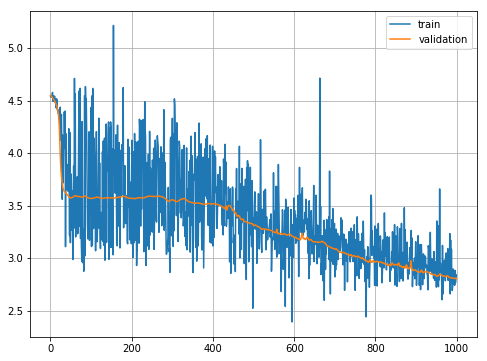

In [7]:
plt.figure(figsize=(8, 6))
plt.plot(losses[0])
plt.plot(losses[1])
plt.legend(('train', 'validation'))
plt.grid(True)

This code is run on Sun Feb 25 19:51:24 PST 2018 for two hours:

In [3]:
def curriculum(epoch):
    if epoch < 400:
        seqs_len = (25, 30)
    elif epoch < 700:
        seqs_len = (50, 80)
    elif epoch < 1000:
        seqs_len = (200, 300)
    elif epoch < 1400:
        seqs_len = (300, 500)
    else:
        seqs_len = (500, 1000)
    return seqs_len

In [5]:
import pickle
with open('201802252110-train_teachingforce_curriculum-2000epochs+losses+curriculum.p', 'rb') as infile:
    net, losses, _ = pickle.load(infile)

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

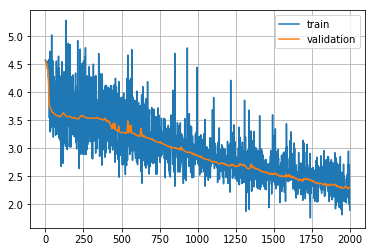

In [9]:
plt.plot(losses[0])
plt.plot(losses[1])
plt.legend(('train', 'validation'))
plt.grid(True)

In [10]:
losses[1][-1]

2.3057010173797607

This code is run on for (same as above, except that now Adam base learning rate is 0.004 instead of
0.001.

In [5]:
filename = '201802252244-train_teachingforce_curriculum-0_004lr-2000epochs+losses.p'
with open(filename, 'rb') as infile:
    net, losses = pickle.load(infile)

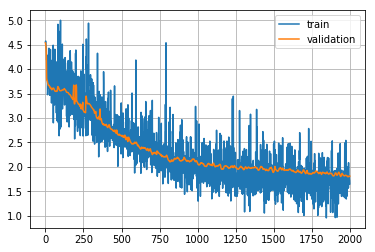

In [6]:
plt.plot(losses[0])
plt.plot(losses[1])
plt.legend(('train', 'validation'))
plt.grid(True)

In [7]:
losses[1][-1]

1.8107374906539917

Same as before, but traing for 3000 epochs

In [1]:
import pickle
import trainlib
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
import torch.nn as nn
%matplotlib inline

In [2]:
with open('201802260059-train_teachingforce_curriculum-0_004lr-3000epochs+losses.p', 'rb') as infile:
    net, losses = pickle.load(infile)

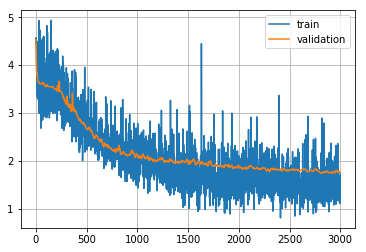

In [3]:
plt.plot(losses[0])
plt.plot(losses[1])
plt.legend(('train', 'validation'))
plt.grid(True)

In [4]:
losses[1][-1]

1.7588279247283936

Same as before, but with 2 layers, each 1000 units.

In [5]:
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

In [2]:
filename = '201802262055-train_teachingforce_curriculum-2layers-0_004lr-3000epochs+losses.p'
with open(filename, 'rb') as infile:
    net, losses = pickle.load(infile)

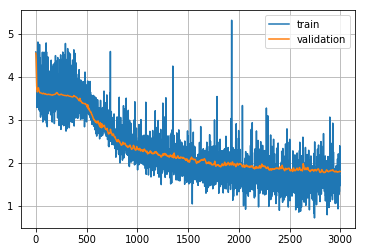

In [6]:
plt.plot(losses[0])
plt.plot(losses[1])
plt.legend(('train', 'validation'))
plt.grid(True)

In [5]:
with open('corpus.p', 'rb') as infile:
    corp = pickle.load(infile)

In [7]:
hidden = (Variable(torch.zeros(1,1,100)), Variable(torch.zeros(1,1,100)))
samples = trainlib.generate(net.cpu(), hidden, corp)

In [12]:
with open('ab-music-gen.abc', 'w') as outfile:
    outfile.write(''.join(samples))

In [19]:
seqs = [[ord('`')]]

In [21]:
inputs = Variable(trainlib.one_hot_tensor(corp, seqs))
hidden = (Variable(torch.zeros(1,1,100)),
          Variable(torch.zeros(1,1,100)))

In [22]:
outputs, hidden = net(inputs, hidden)

In [28]:
softmax = nn.Softmax()
outputs_ = torch.stack([softmax(outputs[i]) for i in range(outputs.size(0))])

In [29]:
outputs_.size()

torch.Size([1, 1, 95])

In [31]:
samples = torch.stack([torch.stack([torch.multinomial(outputs_[i][j], 1)
                                            for j in range(outputs_.size(1))])
                              for i in range(outputs_.size(0))])

In [33]:
samples.view(1, 1)

Variable containing:
 56
[torch.LongTensor of size 1x1]

In [34]:
sample = trainlib.predict(corp, outputs)

In [35]:
sample

Variable containing:
 56
[torch.LongTensor of size 1x1]

In [38]:
sample.view(-1,1).data[0][0]

56

In [13]:
help(trainlib.generate)

Help on function generate in module trainlib:

generate(net, hidden, abc_corp, temperature=1.0, start_symbol='`', end_symbol='$', random_sample=True)



## Backprop on error

In [4]:
from models import SingleLayerLSTMNet
import trainlib
from trainlib import train_teachingforce_curriculum, divide_train_validation
import torch.nn as nn
from torch.autograd import Variable
import pickle
import torch

In [5]:
net = SingleLayerLSTMNet(100, 95)
with open('inputs.p', 'rb') as infile: inputs = pickle.load(infile)
with open('corpus.p', 'rb') as infile: corp = pickle.load(infile)
trainset, validset = divide_train_validation(inputs)

In [6]:
trainlib.train_backprop_on_error(1000, corp, trainset, validset, net, cuda=True)

Exception KeyboardInterrupt in <bound method FilterDescriptor.__del__ of <torch.backends.cudnn.FilterDescriptor object at 0x7f889b1a79d0>> ignored


KeyboardInterrupt: 